In [63]:
import rioxarray as rix
import os
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
import numpy as np
from shapely import geometry
import math
import pandas as pd

# Open surface temperature raster

In [4]:
ls -lah /Users/elischwat/Development/data/sublimationofsnow/RMBL_dronedata/processed/Dronedata_KettlePonds_2024_04_24/mosaics_clipped/cog/

total 75461648
drwxr-xr-x   8 elischwat  staff   256B Oct  7 12:52 ./
drwx------  28 elischwat  staff   896B Oct  7 12:16 ../
-rw-r--r--   1 elischwat  staff   5.5G Oct  7 12:49 LundquistSnowHydro_KettlePonds_Altum_2024_04_24_Flight1_ortho_reflectance_clipped_cog.tif
-rw-r--r--   1 elischwat  staff   3.0G Oct  7 12:50 LundquistSnowHydro_KettlePonds_Altum_2024_04_24_Flight2_ortho_reflectance_clipped_cog.tif
-rw-r--r--   1 elischwat  staff   3.7G Oct  7 12:51 LundquistSnowHydro_KettlePonds_Altum_2024_04_24_Flight3_ortho_reflectance_clipped_cog.tif
-rw-r--r--   1 elischwat  staff   1.0G Oct  7 12:52 LundquistSnowHydro_KettlePonds_P1_2024_04_24_dsm_clipped_cog.tif
-rw-r--r--   1 elischwat  staff   1.1G Oct  7 12:52 LundquistSnowHydro_KettlePonds_P1_2024_04_24_ht_above_DEM_cog.tif
-rw-r--r--   1 elischwat  staff    22G Oct  7 13:04 LundquistSnowHydro_KettlePonds_P1_2024_04_24_ortho_clipped_cog.tif


In [5]:
directory = "/Users/elischwat/Development/data/sublimationofsnow/RMBL_dronedata/processed/Dronedata_KettlePonds_2024_04_24/mosaics_clipped/cog/"

In [6]:
src = rix.open_rasterio(
    os.path.join(directory, "LundquistSnowHydro_KettlePonds_Altum_2024_04_24_Flight1_ortho_reflectance_clipped_cog.tif"),
    chunks='auto',
    masked=True
)

# Decrease resolution from ~2.5cm to 25cm

In [13]:
scale_factor = 0.2
new_width = int(src.sel(band=6).rio.width * scale_factor)
new_height = int(src.sel(band=6).rio.height * scale_factor)
print((new_height, new_width))
irband_lowres = src.sel(band=6).rio.reproject(
    src.rio.crs,
    shape=(new_height, new_width),
)

(5780, 3631)


In [14]:
irband_lowres.rio.resolution()

(0.23785829809973968, -0.23783545806232637)

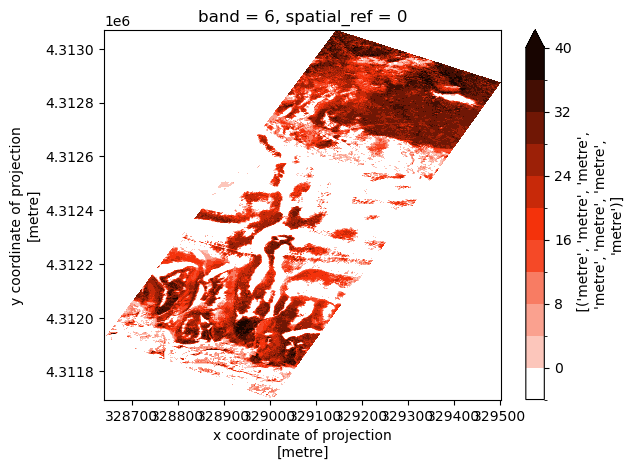

In [16]:
import matplotlib.colors as mcolors
red_scale_colors = [
    # '#FEEBE7',
      '#FCC6BB', '#FAA18F', '#F87C63', '#F54927', '#F4320B', '#C82909', '#9C2007', '#701705', '#440E03', '#180501', 
]
blue = ['#FFFFFF']
# 2. Create a ListedColormap from your colors
custom_cmap = mcolors.ListedColormap(blue + red_scale_colors)
bounds = [irband_lowres.min().item()] + list(np.linspace(0,40,11))
norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
# Plot with the custom colormap and normalization
irband_lowres.plot(cmap=custom_cmap, norm=norm)

# Clip to AOI

In [17]:
bounds = gpd.read_file("/Users/elischwat/Development/data/sublimationofsnow/RMBL_dronedata/vector/bounding_geometry.shp")

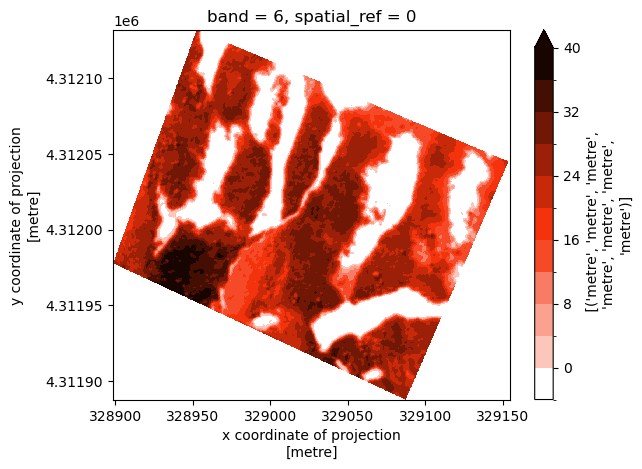

In [20]:
irband_lowres_clipped = irband_lowres.rio.clip(bounds.geometry, drop=True)
irband_lowres_clipped.plot(cmap=custom_cmap, norm=norm)

# Extract data along one line

In [87]:
def calculate_endpoint(x, y, bearing, distance):
    """ Given a starting point, compass bearing, and distance, get an end point
    """    
    # Convert bearing to radians
    bearing_rad = - np.deg2rad(bearing) - np.deg2rad(90)
    # Calculate the new coordinates
    end_x = x - distance * math.cos(bearing_rad)
    end_y = y - distance * math.sin(bearing_rad)
    return end_x, end_y

def create_linestring_from_points(start_x, start_y, end_x, end_y, resolution):
    """ Given two end points, create a LineString with the provided resolution
    """    
    line = geometry.LineString([(start_x, start_y), (end_x, end_y)]) # Create the LineString
    line_length = line.length
    # Generate points at intervals of given reoslution
    num_points = int(line_length / resolution) + 1 
    interpolated_points = [line.interpolate(distance) for distance in np.linspace(0, line_length, num_points)]
    high_res_line = geometry.LineString(interpolated_points) # Create a new LineString with the interpolated points
    return high_res_line

def sample_along_line(line, raster):
    """ Sample from a raster each point in a LineString
    """    
    points = list(line.coords)
    # Initialize a list to store sampled values
    sampled_values = []
    distances = []

    first_point = points[0]
    # Loop through each point and sample the value in irband_lowres
    for point in points:
        x, y = point  # Extract x and y coordinates
        value = raster.sel(x=x, y=y, method="nearest").item()  # Sample value
        sampled_values.append(value)
        distance = np.sqrt((x - first_point[0])**2 + (y - first_point[1])**2)
        distances.append(distance)

    # Convert sampled values to a numpy array (optional)
    sampled_values = np.array(sampled_values)

    sample_df = pd.DataFrame({
        'temp': sampled_values,
        'distance': distances
    }).set_index('distance')
    
    return sample_df

def calculate_temp_segment_lengths(df, root = 0):
    """ Given a dataframe returned from sample_along_line (defined above), 
    calculate the number of and length of contiguous segments with values 
    less than the provided root value
    """    
    # Step 1: Identify segments where temp < 0
    df['below_zero'] = df['temp'] < 0

    # Step 2: Group consecutive indices where temp < 0
    df['segment'] = (df['below_zero'] != df['below_zero'].shift()).cumsum()

    # Step 3: Calculate the length of each segment where temp < 0
    segment_lengths = (
        df[df['below_zero']]
        .groupby('segment')
        .apply(lambda group: group.index[-1] - group.index[0], include_groups=False)
    )
    return segment_lengths

In [55]:
start_x = irband_lowres_clipped.x.min().item()
start_y = irband_lowres_clipped.y.max().item()
end_x, end_y = calculate_endpoint(start_x, start_y, 135, 350)

high_res_line = create_linestring_from_points(start_x, start_y, end_x, end_y, resolution=0.1)

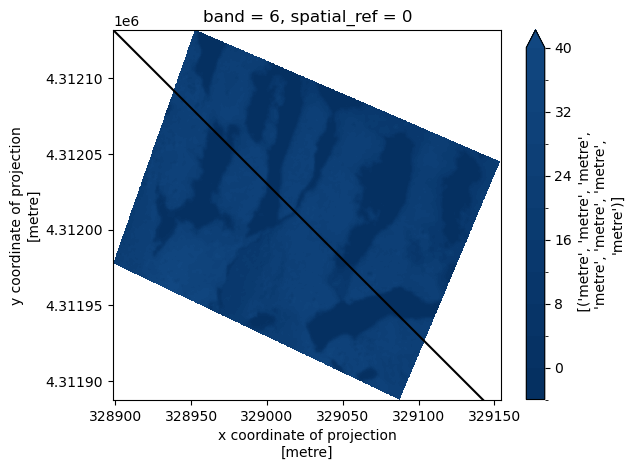

In [56]:
fig, ax = plt.subplots()
gpd.GeoDataFrame(geometry=[high_res_line]).plot(color='black', ax=ax)
irband_lowres.rio.clip(bounds.geometry).plot(cmap=custom_cmap, norm=norm, ax=ax)

In [49]:
sample_df = sample_along_line(high_res_line, irband_lowres)

In [50]:
sample_df['temp'] = sample_df['temp'].rolling(20, center=True).mean()

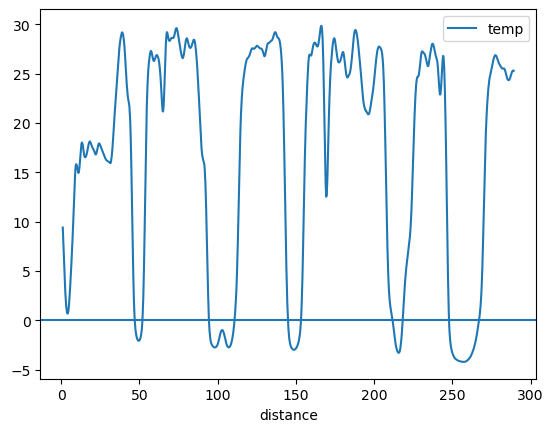

In [51]:
sample_df.plot()
plt.axhline(0)

In [53]:
segment_lengths = calculate_temp_segment_lengths(sample_df, root = 0)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_51564/2571791395.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.index[-1] - group.index[0])


# Extract data along many lines

Create many lines

In [66]:
start_x = irband_lowres_clipped.x.min().item()
start_y = irband_lowres_clipped.y.max().item()

start_points = []
start_points = start_points + [geometry.Point(start_x, start_y)]

for adj in np.linspace(0, 125, 26):
    start_points = start_points + [
        geometry.Point(start_x, start_y + adj),
        geometry.Point(start_x, start_y - adj)
    ]

In [79]:
end_points = [geometry.Point(calculate_endpoint(pt.x, pt.y, 135, 350)) for pt in start_points]
lines = [
    create_linestring_from_points(start_pt.x, start_pt.y, end_pt.x, end_pt.y, resolution=0.1) 
    for (start_pt, end_pt) in zip(start_points, end_points)
]

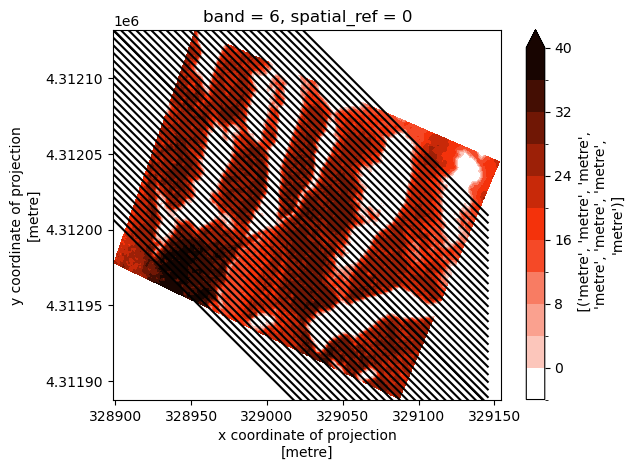

In [82]:
fig, ax = plt.subplots()
gpd.GeoDataFrame(geometry=lines).plot(color='black', ax=ax)
irband_lowres.rio.clip(bounds.geometry).plot(cmap=custom_cmap, norm=norm, ax=ax)

In [83]:
samples = [sample_along_line(line, irband_lowres) for line in lines]

In [85]:
samples = [df.assign(temp = df['temp'].rolling(20, center=True).mean()) for df in samples]

In [88]:
segment_lengths_list = [
    calculate_temp_segment_lengths(df, root = 0) for df in samples
]

In [98]:
import altair as alt

In [105]:
src = pd.DataFrame(pd.Series(segment_lengths_list).rename('patch_length').explode())
src.head()

,patch_length
0,4.9
0,16.2
0,8.2
0,6.3
0,19.1


In [108]:
alt.Chart(
    src
).mark_bar().encode(
    alt.X('patch_length:Q').bin(step=1),
    alt.Y('count():Q')
)

alt.Chart(...)